In [ ]:
BASE_FOLDER = "HistoQuant/SDH_classify/"

In [5]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

2022-06-13 15:05:55.883765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-13 15:05:55.883836: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
import glob
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.image import resize_with_crop_or_pad

def generate_data_arrays(BASE_FOLDER):
    n_train = len(glob.glob(BASE_FOLDER+"train/*.tif"))
    n_val = len(glob.glob(BASE_FOLDER+"validation/*.tif"))
    n_test = len(glob.glob(BASE_FOLDER+"test/*.tif"))
    counter = 0
    train_images = np.empty(shape=(n_train, 224, 224, 3), dtype=np.float32)
    train_labels = np.empty(shape=(n_train, 1), dtype=np.int8)
    val_images = np.empty(shape=(n_val, 224, 224, 3), dtype=np.float32)
    val_labels = np.empty(shape=(n_val, 1), dtype=np.int8)
    test_images = np.empty(shape=(n_test, 224, 224, 3), dtype=np.float32)
    test_labels = np.empty(shape=(n_test, 1), dtype=np.int8)

    for image in glob.glob(BASE_FOLDER+"train/*.tif"):
        im = np.asarray(Image.open(image))
        im_resized = resize_with_crop_or_pad(im, 224, 224)
        train_images[counter] = im_resized
        train_labels[counter] = int(image.split("/")[-1].split("_")[0])
        counter += 1
    
    counter = 0
    for image in glob.glob(BASE_FOLDER+"validation/*.tif"):
        im = np.asarray(Image.open(image))
        im_resized = resize_with_crop_or_pad(im, 224, 224)
        val_images[counter] = im_resized
        val_labels[counter] = int(image.split("/")[-1].split("_")[0])
        counter += 1
    
    counter = 0
    for image in glob.glob(BASE_FOLDER+"test/*.tif"):
        im = np.asarray(Image.open(image))
        im_resized = resize_with_crop_or_pad(im, 224, 224)
        test_images[counter] = im_resized
        test_labels[counter] = int(image.split("/")[-1].split("_")[0])
        counter += 1

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [21]:
# model = ResNet50(weights='imagenet')
# model.summary()
train_images, train_labels, val_images, val_labels, test_images, test_labels = generate_data_arrays(BASE_FOLDER)

In [23]:
train_images, val_images, test_images = train_images/255.0, val_images/255.0, test_images/255.0

In [45]:
class_weights_numpy = np.unique(train_labels, return_counts=True)
n_train = len(train_labels)
class_weights = {class_weights_numpy[0][0]: class_weights_numpy[1][0]/n_train, class_weights_numpy[0][1]: class_weights_numpy[1][1]/n_train}

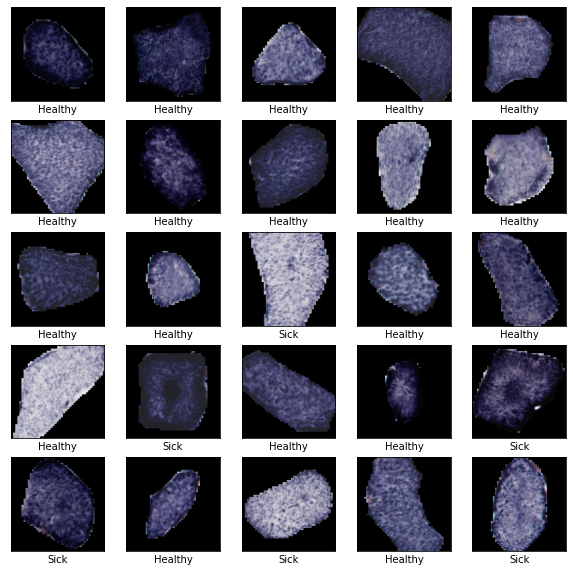

In [24]:
import matplotlib.pyplot as plt
class_names = ['Healthy', 'Sick']

plt.figure(figsize=(10,10))
counter = 0
for i in np.random.choice(range(len(train_images)),25):
    plt.subplot(5,5,counter+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
    counter +=1
plt.show()


In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 flatten_1 (Flatten)         (None, 173056)           

In [28]:
epochs = 200

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=epochs, 
                    validation_data=(val_images, val_labels), shuffle=True, class_weights=class_weights)

Epoch 1/10


2022-06-13 16:20:59.184925: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 2266349568 exceeds 10% of free system memory.


118/118 [==============================] - 82s 687ms/step - loss: 0.6510 - accuracy: 0.7027 - val_loss: 0.5968 - val_accuracy: 0.7112
Epoch 2/10
118/118 [==============================] - 80s 678ms/step - loss: 0.5746 - accuracy: 0.7152 - val_loss: 0.6001 - val_accuracy: 0.6635
Epoch 3/10
118/118 [==============================] - 80s 679ms/step - loss: 0.4969 - accuracy: 0.7633 - val_loss: 0.6116 - val_accuracy: 0.7184
Epoch 4/10
118/118 [==============================] - 80s 674ms/step - loss: 0.3581 - accuracy: 0.8486 - val_loss: 0.6243 - val_accuracy: 0.7327
Epoch 5/10
118/118 [==============================] - 79s 673ms/step - loss: 0.1764 - accuracy: 0.9336 - val_loss: 0.9337 - val_accuracy: 0.7088
Epoch 6/10
118/118 [==============================] - 79s 669ms/step - loss: 0.0675 - accuracy: 0.9732 - val_loss: 1.2421 - val_accuracy: 0.6897
Epoch 7/10
118/118 [==============================] - 80s 674ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 2.0076 - val_accuracy: 0.7

14/14 - 2s - loss: 2.5564 - accuracy: 0.7232 - 2s/epoch - 119ms/step


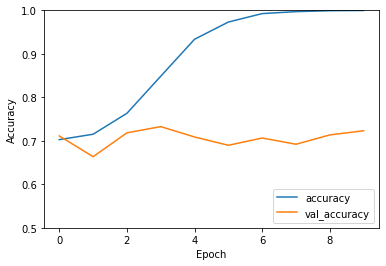

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [33]:
print(val_acc)

0.723150372505188


In [35]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print("Test data results: ")
print(test_acc)

33/33 - 4s - loss: 2.0502 - accuracy: 0.7488 - 4s/epoch - 123ms/step
Test data results: 
0.7488061189651489
